# **Sport Image Classification**

### Team Members :
- FASSIER Thimothé
- LE ROUX Thomas
- MONGKHOUN Vincent

In this project, we are going to build a sport-image classifier. The model will take as an input an image and will return as an output the sport that is represented in it.

During this project, we have used some fonctions that were introduced during lecture labs about CNN and Computer Vision of this course.

This notebook of the project is divided into 4 parts :
- **Data Exploration and Data Pre-processing**
- **Transfer Learning with CNN features extraction**
- **Transfer Learning with Fine Tuning**

# Importation of packages

In [1]:
import tensorflow as tf
import torch
import keras
from tensorflow import keras
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import cv2

from IPython.display import Image
import matplotlib.cm as cm

import os
import shutil

import warnings
warnings.filterwarnings("ignore")

# Downloading the dataset

If the dataset is not already dowloaded, follow the following steps : 
- Download the datset with the following link : https://www.kaggle.com/datasets/rishikeshkonapure/sports-image-dataset/download
- Unzip and place the dataset in the same folder as this notebook

# Data Exploration and Pre-Processing

## Test-data creation

The original dataset doesn't provide a folder where test data are located. Consequently, before beginning the data exploration and pre-precossing, we need to allocate some images as test data for the testing phase of our trained model

In [2]:
environment = 'kaggle'

if environment == 'kaggle' : 
    DATASET_DIR = '../input/sports-image-dataset/sports-image-dataset'
elif environment == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    DATASET_DIR = '/content/drive/My Drive/Applied DL Project/sports-image-dataset/'
else :
    DATASET_DIR = './sports-image-dataset'

DATA_DIR = os.path.join(DATASET_DIR, 'data')
sports = os.listdir(DATA_DIR)

print('The sports that our model will classify are the following :')
print(sports)

The sports that our model will classify are the following :
['ice_hockey', 'volleyball', 'tennis', 'fencing', 'football', 'shooting', 'table_tennis', 'swimming', 'baseball', 'badminton', 'chess', 'weight_lifting', 'kabaddi', 'wrestling', 'gymnastics', 'boxing', 'basketball', 'cricket', 'motogp', 'formula1', 'hockey', 'wwe']


Let create a test data subfolder to store the data that will be used for the testing phase. We randomly select the data from each classes 

In [3]:
# Creation of the test subfolder and the dataset

n_validation = 100

test_folder = os.path.join(DATASET_DIR, 'test_data')
if not os.path.exists(test_folder):
    os.mkdir(test_folder)
    for class_name in sports:
        train_subfolder = os.path.join(DATA_DIR, class_name)
        test_subfolder = os.path.join(test_folder, class_name)
        print("Populating %s..." % test_subfolder)
        os.mkdir(test_subfolder)
        images_filenames = sorted(os.listdir(train_subfolder))
        for image_filename in images_filenames[-n_validation:]:
            shutil.move(os.path.join(train_subfolder, image_filename),
                        test_subfolder)
        print("Moved %d images" % len(os.listdir(test_subfolder)))

## Creation of the tensorflow-datasets

As we have a set of images from our dataset that are filed into class-specific folders, we will use the method <code>tf.keras.utils.image_dataset_from_directory</code> to automatically process the data directly from the train subfolder and also to generate similar labeled dataset objects. 

We divide the data into 80% for the train dataset and 20% for the validation dataset.

In [4]:
batch_size = 32
img_height = 224
img_width = 224

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='rgb')

Found 12009 files belonging to 22 classes.
Using 9608 files for training.


2022-03-30 12:50:36.748568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 12:50:36.749611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 12:50:36.750385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 12:50:36.752321: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='rgb')

Found 12009 files belonging to 22 classes.
Using 2401 files for validation.


We can check if everything is good by looking at the shape of one batch

In [7]:
# Check how the images are arranged within a batch 
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

2022-03-30 12:50:42.369281: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 224, 224, 3)
(32,)


Everything seems to be good as a batch of size 32 and the images are correctly converted into (img_height, img_width, nb_channels) format.

## Data Exploration

In [8]:
class_names = train_dataset.class_names
nb_sports = len(class_names)
print('We will classify the folliwing sports : ' + str(class_names))
print('There is a total of ' + str(nb_sports) + ' sports')

We will classify the folliwing sports : ['badminton', 'baseball', 'basketball', 'boxing', 'chess', 'cricket', 'fencing', 'football', 'formula1', 'gymnastics', 'hockey', 'ice_hockey', 'kabaddi', 'motogp', 'shooting', 'swimming', 'table_tennis', 'tennis', 'volleyball', 'weight_lifting', 'wrestling', 'wwe']
There is a total of 22 sports


In order to quickly switch between the name of the sport and the corresponding label, we define the following dictionay :

In [9]:
# Create a quick path between label and sport
INDEX_TO_CLASS = {k: v for k, v in enumerate(class_names)}
INDEX_TO_CLASS

{0: 'badminton',
 1: 'baseball',
 2: 'basketball',
 3: 'boxing',
 4: 'chess',
 5: 'cricket',
 6: 'fencing',
 7: 'football',
 8: 'formula1',
 9: 'gymnastics',
 10: 'hockey',
 11: 'ice_hockey',
 12: 'kabaddi',
 13: 'motogp',
 14: 'shooting',
 15: 'swimming',
 16: 'table_tennis',
 17: 'tennis',
 18: 'volleyball',
 19: 'weight_lifting',
 20: 'wrestling',
 21: 'wwe'}

We can now plot one image of each class to see what it's look like

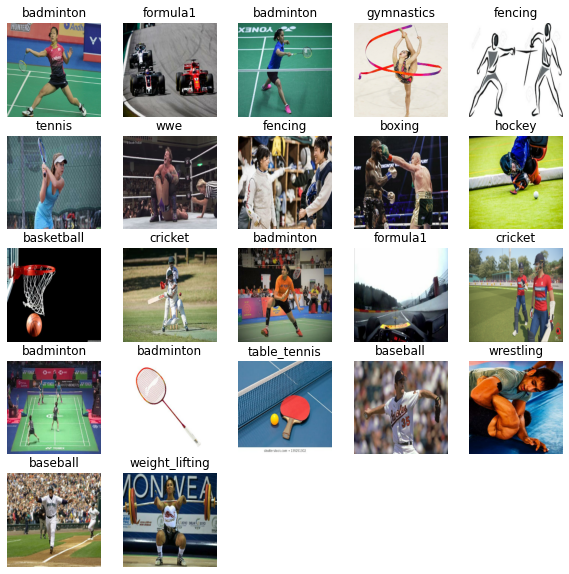

In [10]:
# Plot one image per class
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(22):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

Let's now see what the images from the same class looks like. We first define a function that plot the different images from the same class

In [11]:
def plot_classes(random_sport):
    '''Plot images from the same class'''

    n_rows = 3
    n_cols = 4
    sport_folder = os.path.join(DATA_DIR, random_sport)
    list_img = os.listdir(sport_folder)
    
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index+1)

            # Pick a random images to plot
            for i in range(8):
                x = random.randint(0, len(list_img) - 2)
                image_ = plt.imread(os.path.join(sport_folder, list_img[x]))
                # Display the image
                plt.imshow(image_, cmap='binary', interpolation='nearest')
                plt.title(random_sport)
                plt.axis('off')

    plt.tight_layout()
    plt.show()

The selected sport to display various images is FOOTBALL


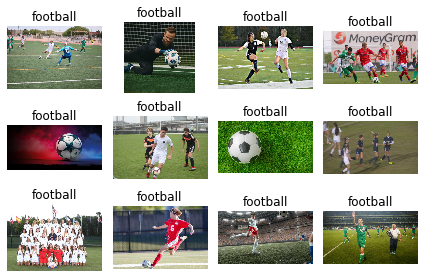

In [12]:
#random_sport = INDEX_TO_CLASS[random.randint(0, nb_sports)]
random_sport = 'football'
print(f'The selected sport to display various images is {random_sport.upper()}')

plot_classes(random_sport)

The selected sport to display various images is HOCKEY


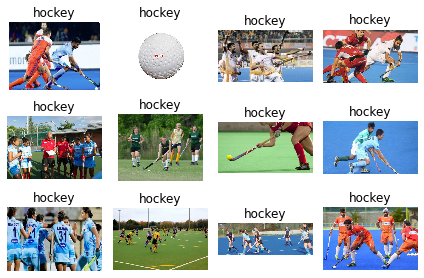

In [13]:
#random_sport = INDEX_TO_CLASS[random.randint(0, nb_sports)]
random_sport = 'hockey'
print(f'The selected sport to display various images is {random_sport.upper()}')

plot_classes(random_sport)

The selected sport to display various images is BADMINTON


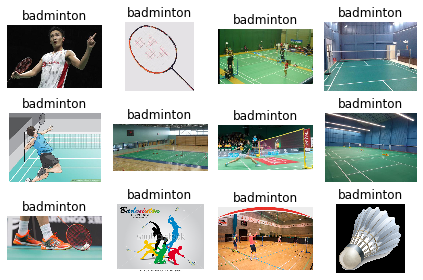

In [14]:
random_sport = INDEX_TO_CLASS[random.randint(0, nb_sports)]
print(f'The selected sport to display various images is {random_sport.upper()}')

plot_classes(random_sport)

We remark that within the same class, images are quiet different in term of orientation, color, zoom range or even light levels. There are even images of the equipment only, such as for hockey, basketball, badminton or football. The model should be agnostic or robust to these variations.  The idea of using data augmention becomes pertinent, and it's all the more the case as the train dataset is quite small for this type of case (Image Classification).


**Remark :** the images are not in the same size here but there will have the same during the training (cf Creation of Tensorflow Dataset section)

Let's check the number of images per each classes

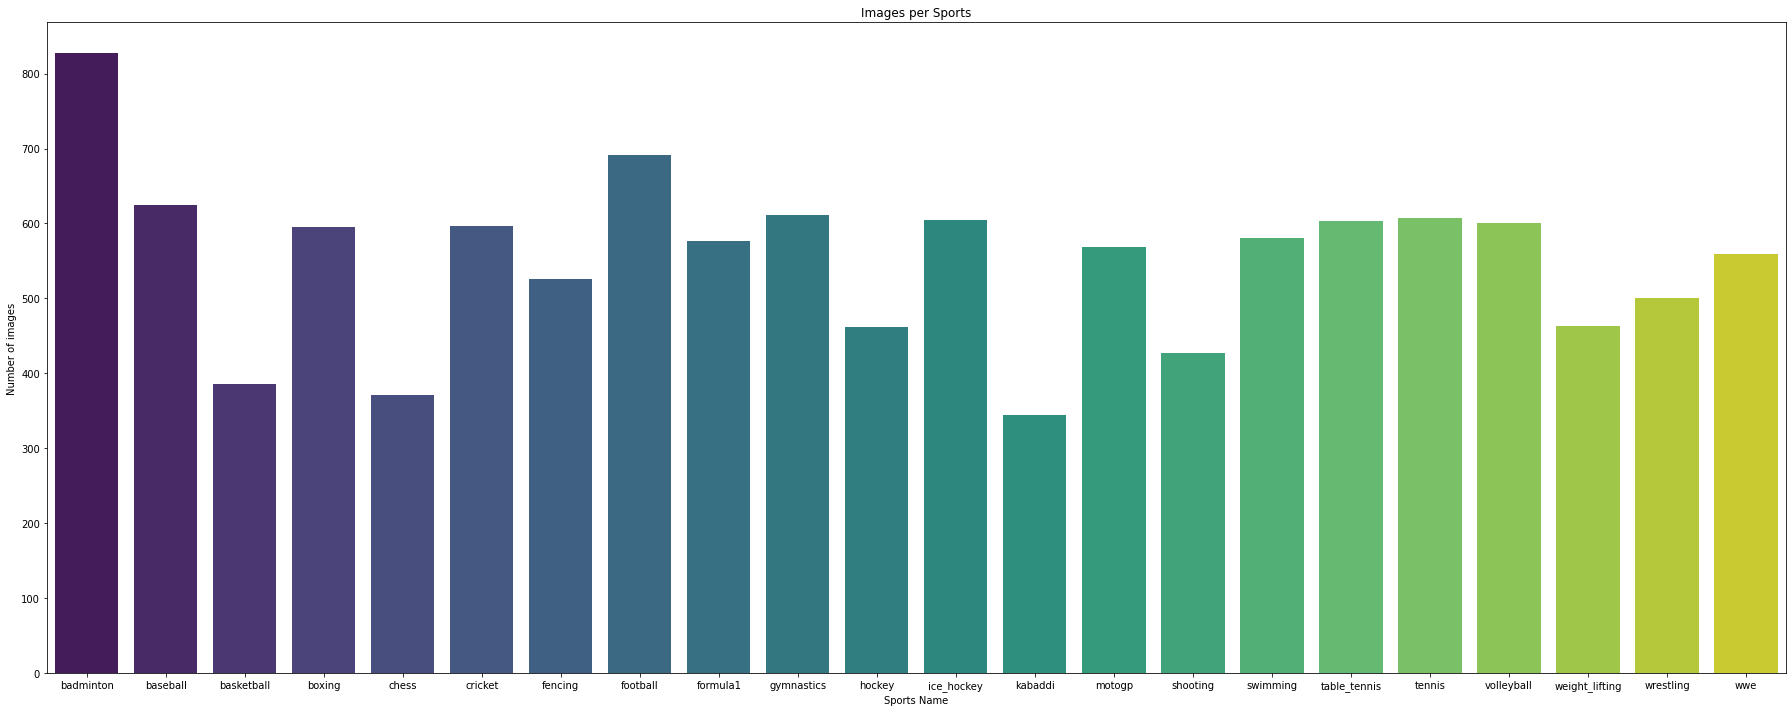

In [15]:
effectifs = []
for sport in class_names:
    effectif = os.listdir(os.path.join(DATA_DIR, sport))
    effectifs.append(len(effectif))

plt.figure(figsize=(25, 10))
sns.barplot(x=class_names, y=effectifs, palette='viridis')
plt.title('Images per Sports',)
plt.ylabel('Number of images')
plt.xlabel('Sports Name')
plt.tight_layout()
plt.show()

The 2 sports that are the most represented in the dataset are firstly Badminton and secondly Football. On the contrary, the ones that are the less represented are Basketball, Kabaddi and Chess. 

## Data-Preprocessing

We first configure the performance of the dataset.

The <code>Dataset.cache</code> keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training our model.

The <code>Dataset.prefetch</code> overlaps data preprocessing and model execution while training.

In [16]:
train_dataset = train_dataset.cache().prefetch(buffer_size=10)
val_dataset = val_dataset.cache().prefetch(buffer_size=10)

We can now configure the different data augmentation process that we will use during the training. Regarding the different variation of images within the same class, we have decided to do : 
- Horizontal and Vertical <code>RandomFlip</code>
- <code>RandomRotation</code> 

In [17]:
# Create the random data augmentation 
data_augmentation = tf.keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal"),
     tf.keras.layers.RandomRotation(0.1),
    ]
)

We can test if everything works well for one image

2022-03-30 12:50:53.533571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2022-03-30 12:50:53.603620: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


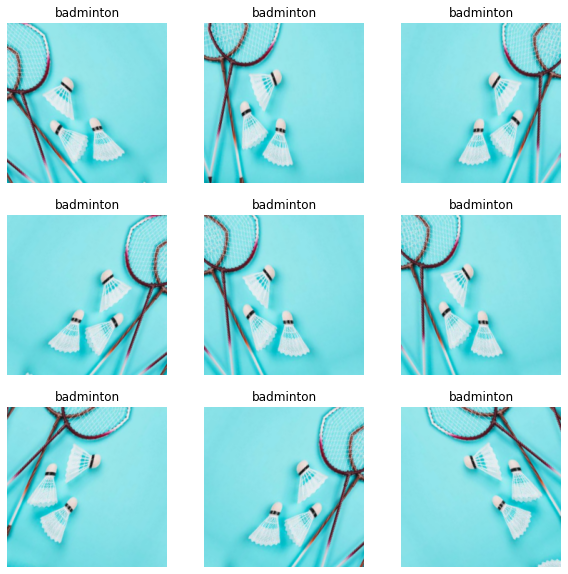

In [18]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(INDEX_TO_CLASS[int(labels[0])])
        plt.axis("off")
plt.show()

# Transfer Learning with CNN Feature Extraction

In this section, we will implement a Transfer Learning model. We will use a pretrained CNN in order to process feature extraction. The aim is to, from a previous network, extract meaningful features from new samples. We will finally add a new model on top of this pretrained model so that we can repurpose the feature maps learned previously for the dataset.

## The model

The CNN that we are using is the <code>ResNet50</code> model, which is a quite good model that present a good balance between performance and time of computation

For feature extraction, we specify the <code>include_top=False</code> argument, so that when we load the network, it doesn't include the classification layers at the top. 

In [19]:
base_model = tf.keras.applications.resnet50.ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  

94781440/94765736 [==============================] - 0s 0us/step


We want to prevent the weights in a given layer of the <code>based_model</code> from being updated during training, so we freeze it : 

In [20]:
# Freeze the base_model
base_model.trainable = False

# Let's see at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Once we have freezed the original top layer of the <code>ResNet50</code>, we can add our own classifier on the top of the model so it will be ready to be train with our own data.

In [21]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))

# Data augmentation
x = data_augmentation(inputs)

# Pre-processing the data in order to be fed to the model
x = preprocess_input(x)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# Regularization
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(22, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

We can now proceed to the training. We have decided to choose the following parameters : 
- <code>SGD</code> optimizer with default value of learning rate
- <code>SparseCategoricalCrossentropy</code> loss as we didn't onehot encoded our labels and that we 22 labels and not 2 (otherwise it we be <code>CategoricalCrossentropy</code>)
- <code>SparseCategoricalAccuracy</code> metric 

In [22]:
# Definition of the optimization parameters and of the metric

model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [23]:
# Training

initial_epochs = 20
history_tl = model.fit(train_dataset,
                       epochs=initial_epochs,
                       validation_data=val_dataset)

Epoch 1/20


2022-03-30 12:50:59.965450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2022-03-30 12:51:00.704294: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 54/301 [====>.........................] - ETA: 28s - loss: 2.4554 - sparse_categorical_accuracy: 0.3223

2022-03-30 12:51:12.134277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/301 [=========>....................] - ETA: 24s - loss: 1.9775 - sparse_categorical_accuracy: 0.4436

2022-03-30 12:51:19.625659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/301 [===========>..................] - ETA: 22s - loss: 1.8859 - sparse_categorical_accuracy: 0.4690

2022-03-30 12:51:21.708317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/301 [===========>..................] - ETA: 22s - loss: 1.8756 - sparse_categorical_accuracy: 0.4717

2022-03-30 12:51:22.087513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/301 [============>.................] - ETA: 21s - loss: 1.8257 - sparse_categorical_accuracy: 0.4845

2022-03-30 12:51:23.138767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2022-03-30 12:51:23.161577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/301 [=============>................] - ETA: 20s - loss: 1.7851 - sparse_categorical_accuracy: 0.4940

2022-03-30 12:51:24.164924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


147/301 [=============>................] - ETA: 20s - loss: 1.7604 - sparse_categorical_accuracy: 0.4987

2022-03-30 12:51:25.080755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 12:51:25.089669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/301 [===============>..............] - ETA: 18s - loss: 1.7024 - sparse_categorical_accuracy: 0.5148

2022-03-30 12:51:27.065360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/301 [===============>..............] - ETA: 17s - loss: 1.6822 - sparse_categorical_accuracy: 0.5206

2022-03-30 12:51:27.871584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/301 [================>.............] - ETA: 17s - loss: 1.6701 - sparse_categorical_accuracy: 0.5250

2022-03-30 12:51:28.410916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/301 [==================>...........] - ETA: 14s - loss: 1.6009 - sparse_categorical_accuracy: 0.5453

2022-03-30 12:51:31.268060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/301 [==================>...........] - ETA: 13s - loss: 1.5812 - sparse_categorical_accuracy: 0.5494

2022-03-30 12:51:32.503365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/301 [===================>..........] - ETA: 12s - loss: 1.5551 - sparse_categorical_accuracy: 0.5566

2022-03-30 12:51:33.569759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 12:51:33.764888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/301 [======================>.......] - ETA: 9s - loss: 1.4873 - sparse_categorical_accuracy: 0.5751

2022-03-30 12:51:37.265108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/301 [========================>.....] - ETA: 6s - loss: 1.4356 - sparse_categorical_accuracy: 0.5874

2022-03-30 12:51:40.360394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 12:51:40.459269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


301/301 [==============================] - ETA: 0s - loss: 1.3564 - sparse_categorical_accuracy: 0.6082

2022-03-30 12:51:49.795833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2022-03-30 12:51:54.624646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 12:51:55.262525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 12:51:55.563264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 12:51:57.922340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


301/301 [==============================] - 63s 176ms/step - loss: 1.3564 - sparse_categorical_accuracy: 0.6082 - val_loss: 0.6667 - val_sparse_categorical_accuracy: 0.8067
Epoch 2/20
301/301 [==============================] - 23s 75ms/step - loss: 0.7599 - sparse_categorical_accuracy: 0.7751 - val_loss: 0.5533 - val_sparse_categorical_accuracy: 0.8334
Epoch 3/20
301/301 [==============================] - 23s 75ms/step - loss: 0.6369 - sparse_categorical_accuracy: 0.8114 - val_loss: 0.5191 - val_sparse_categorical_accuracy: 0.8451
Epoch 4/20
301/301 [==============================] - 23s 75ms/step - loss: 0.5703 - sparse_categorical_accuracy: 0.8298 - val_loss: 0.4665 - val_sparse_categorical_accuracy: 0.8588
Epoch 5/20
301/301 [==============================] - 23s 75ms/step - loss: 0.5263 - sparse_categorical_accuracy: 0.8452 - val_loss: 0.4638 - val_sparse_categorical_accuracy: 0.8638
Epoch 6/20
301/301 [==============================] - 23s 75ms/step - loss: 0.4962 - sparse_categori

## Perfomance of the model

### Loss and Accuracy

We can now look at learning curves of the training and validation accuracy/loss

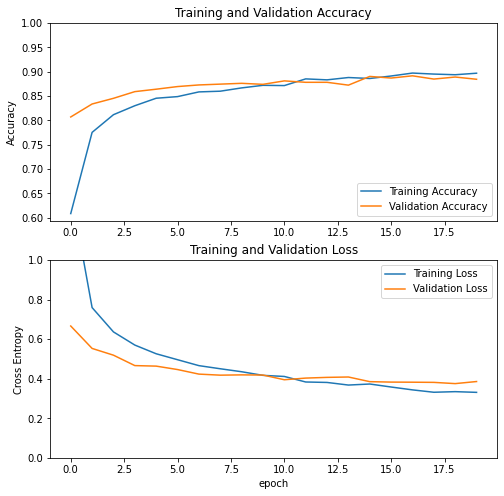

In [24]:
acc = history_tl.history['sparse_categorical_accuracy']
val_acc = history_tl.history['val_sparse_categorical_accuracy']

loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Prediction of new samples and analysis

In [25]:
TEST_DATA = os.path.join(DATASET_DIR, 'test_data')

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DATA,
    image_size=(img_height, img_width),
    color_mode='rgb')

Found 2175 files belonging to 22 classes.


In [26]:
predictions = []
true_labels = []
imgs = []

for X, y in test_dataset :
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()
    pred = model.predict_on_batch(image_batch)
    pred = tf.nn.softmax(pred)
    imgs.append(image_batch)
    true_labels.append(label_batch)
    predictions.append(np.argmax(pred.numpy(),axis=1))

2022-03-30 13:01:59.496406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:02:00.431779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:02:02.058888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:02:03.004839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:02:04.376001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:02:05.021778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2022-03-30 13:02:05.066117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:02:05.780751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:02:06.500662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning

In [27]:
imgs = [item for sublist in imgs for item in sublist]
predictions = [item for sublist in predictions for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

In [28]:
predictions_sports = [INDEX_TO_CLASS[k] for k in predictions]
true_labels_sports = [INDEX_TO_CLASS[k] for k in true_labels]

In [29]:
loss_pred, accuracy = model.evaluate(test_dataset)
print("Test loss :", loss_pred)
print("Test accuracy :", accuracy)

2022-03-30 13:03:11.624536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/68 [==>...........................] - ETA: 7s - loss: 0.6101 - sparse_categorical_accuracy: 0.8259

2022-03-30 13:03:12.514914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


42/68 [=================>............] - ETA: 2s - loss: 0.6272 - sparse_categorical_accuracy: 0.8244

2022-03-30 13:03:16.053956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


49/68 [====================>.........] - ETA: 1s - loss: 0.6371 - sparse_categorical_accuracy: 0.8182

2022-03-30 13:03:16.747403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/68 [==============================] - 7s 98ms/step - loss: 0.6501 - sparse_categorical_accuracy: 0.8124
Test loss : 0.6500980257987976
Test accuracy : 0.8124138116836548


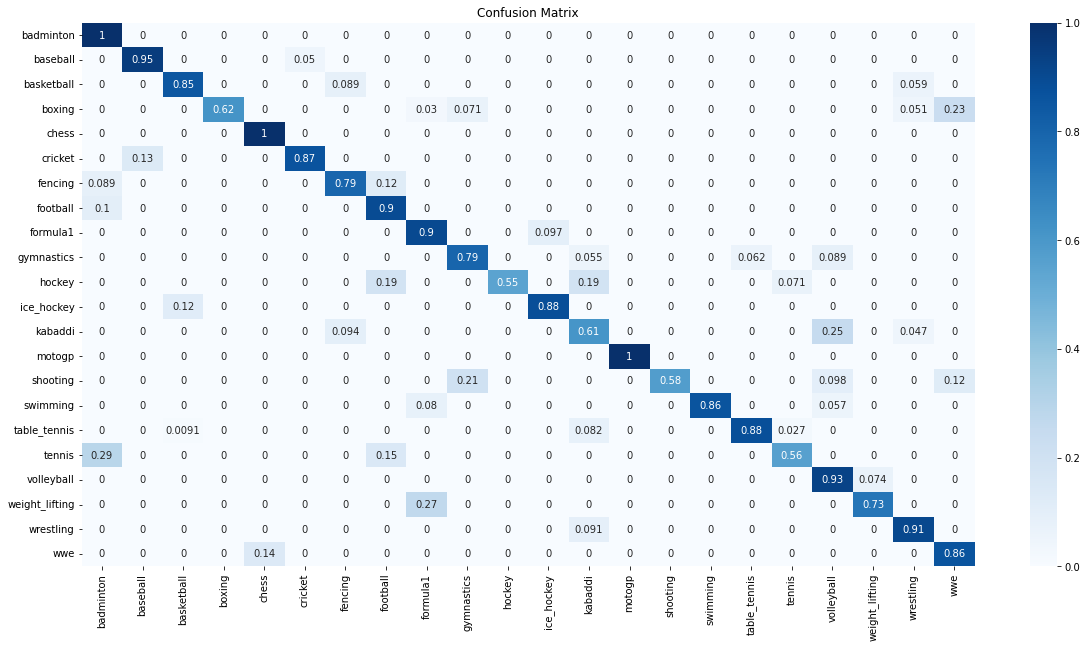

In [30]:
cf_matrix = confusion_matrix(true_labels_sports, predictions_sports, normalize='true')
plt.figure(figsize=(20, 10))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=sorted(
    set(true_labels_sports)), yticklabels=sorted(set(true_labels_sports)))
plt.title('Confusion Matrix')
plt.show()

In [31]:
from sklearn.metrics import classification_report
 
print(classification_report(true_labels_sports, predictions_sports, target_names=class_names))

                precision    recall  f1-score   support

     badminton       0.79      1.00      0.88       113
      baseball       0.88      0.95      0.92       121
    basketball       0.88      0.85      0.86       101
        boxing       1.00      0.62      0.76        99
         chess       0.93      1.00      0.96        91
       cricket       0.94      0.87      0.90       112
       fencing       0.84      0.79      0.82       101
      football       0.70      0.90      0.78        87
      formula1       0.72      0.90      0.80       145
    gymnastics       0.82      0.79      0.81       146
        hockey       1.00      0.55      0.71        84
    ice_hockey       0.86      0.88      0.87        95
       kabaddi       0.49      0.61      0.54        64
        motogp       1.00      1.00      1.00        96
      shooting       1.00      0.58      0.73        92
      swimming       1.00      0.86      0.93        87
  table_tennis       0.92      0.88      0.90  

### Heatmap Visualization 

In general, a CNN is often qualify as a "black box" because people doesn't really understand what a model learn exactly during training or how i it takes a decision for a prediction. In order to more understand that, one interesting thing to do is to visualize what, for a given image, the model focuses on in order to predict the corresponding label. That is why in the following cells, we are going to plot what is called Heatmap.

We will implement the method, called Grad-CAM, that is introduced in the following research paper : https://arxiv.org/abs/1610.02391#:~:text=Our%20approach%20%2D%20Gradient%2Dweighted%20Class,image%20for%20predicting%20the%20concept.


#### Grad-CAM

The following cell implements the Grad-CAM method is inspired from the following tutorial: 
https://keras.io/examples/vision/grad_cam/

We adapt this to our model

In [32]:
# The Grad-CAM algorithm
def get_img_array(img_path, size=(224,224,3)):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, base_model, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(base_model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

#### Heatmap for our model

Firstly, we have to get the last convolution layer of the pretrained model (e.g. <code>ResNet50</code> in our case) and the predicition layers and store them in two variables called respectively <code>last_conv_layer_name</code>, and <code>classifier_layer_names</code>

In [33]:
for layer in model.layers:
    print(layer.name)

input_2
sequential
tf.__operators__.getitem
tf.nn.bias_add
resnet50
global_average_pooling2d
dropout
dense


In [34]:
resnet50_model = model.layers[4]

In [35]:
for layer in resnet50_model.layers:
    print(layer.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [36]:
last_conv_layer_name = "conv5_block3_out"
classifier_layer_names = [layer.name for layer in model.layers][5:]

We can now plot the heatmap of images from the testing dataset and see, for each class, what the model is focusing on the make a prediction

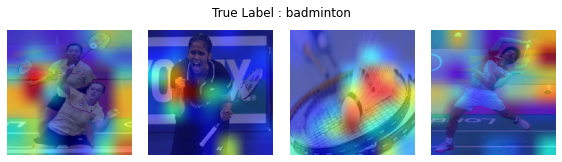

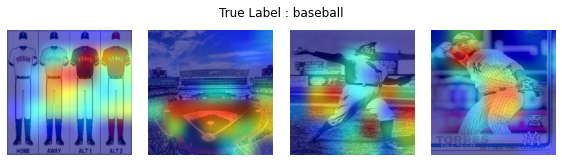

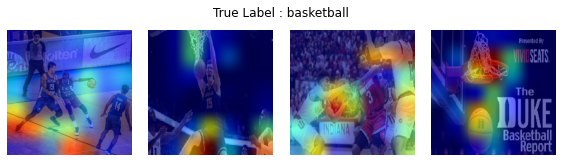

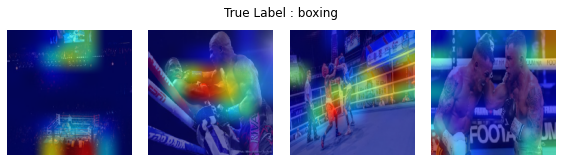

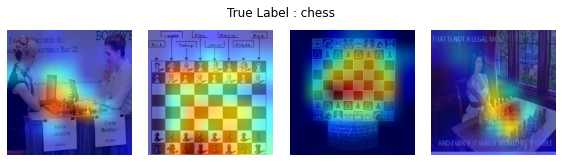

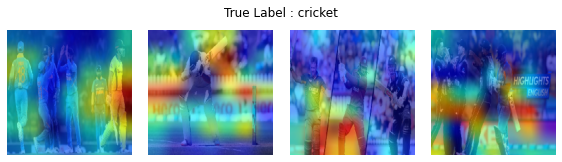

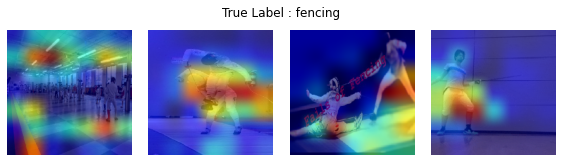

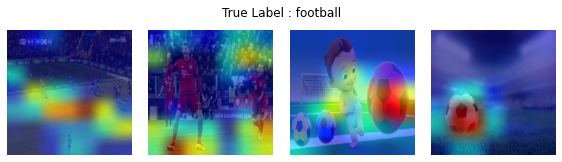

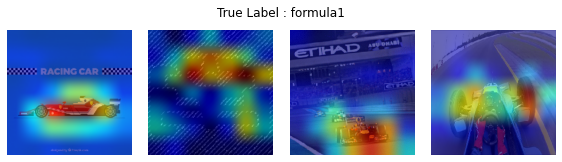

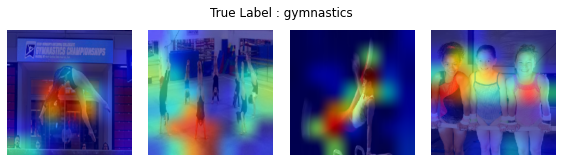

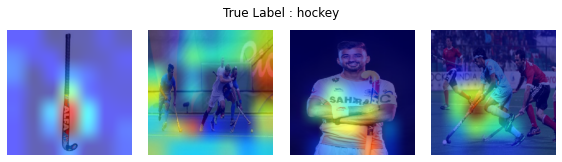

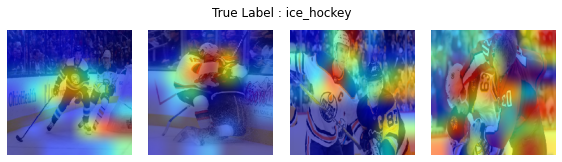

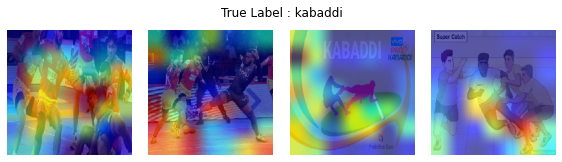

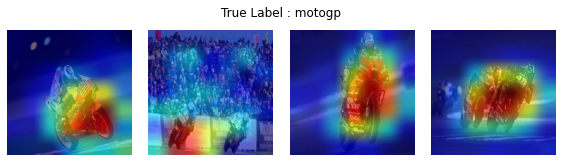

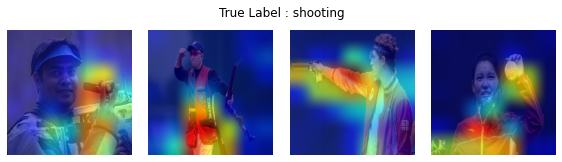

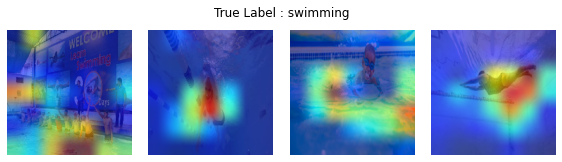

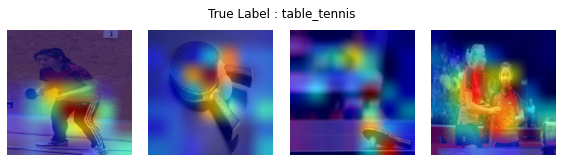

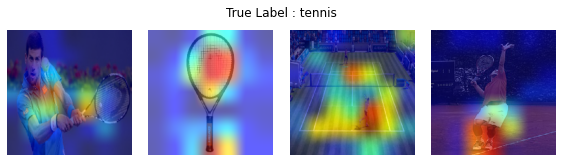

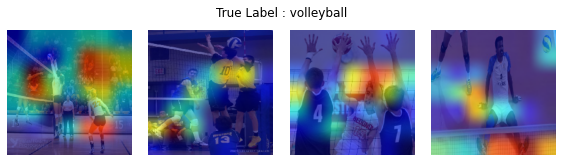

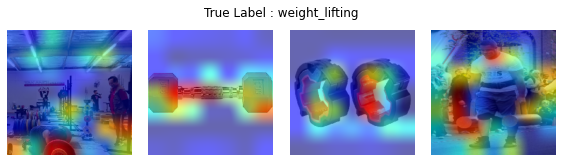

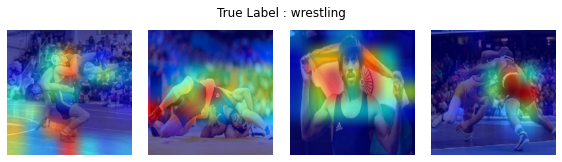

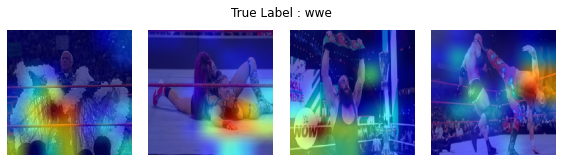

In [37]:
for sport in class_names:
    sport_folder = os.path.join(TEST_DATA, sport)
    sport_list = os.listdir(sport_folder)
    
    #img1_path = os.path.join(sport_folder, sport_list[random.randint(0, len(sport_list)-1)])
    #img2_path = os.path.join(sport_folder, sport_list[random.randint(0, len(sport_list)-1)])
    
    img1_path = os.path.join(sport_folder, sport_list[0])
    img2_path = os.path.join(sport_folder, sport_list[1])
    img3_path = os.path.join(sport_folder, sport_list[2])
    img4_path = os.path.join(sport_folder, sport_list[3])
    
    img1 = tf.keras.utils.load_img(img1_path, target_size=(224,224,3))
    img1 = keras.preprocessing.image.img_to_array(img1)
    img2 = tf.keras.utils.load_img(img2_path, target_size=(224,224,3))
    img2 = keras.preprocessing.image.img_to_array(img2)
    img3 = tf.keras.utils.load_img(img3_path, target_size=(224,224,3))
    img3 = keras.preprocessing.image.img_to_array(img3)
    img4= tf.keras.utils.load_img(img4_path, target_size=(224,224,3))
    img4 = keras.preprocessing.image.img_to_array(img4)
  
    heatmap1 = make_gradcam_heatmap(tf.expand_dims(img1,axis=0), resnet50_model, model, last_conv_layer_name, classifier_layer_names)
    heatmap2 = make_gradcam_heatmap(tf.expand_dims(img2,axis=0), resnet50_model, model, last_conv_layer_name, classifier_layer_names)
    heatmap3 = make_gradcam_heatmap(tf.expand_dims(img3,axis=0), resnet50_model, model, last_conv_layer_name, classifier_layer_names)
    heatmap4 = make_gradcam_heatmap(tf.expand_dims(img4,axis=0), resnet50_model, model, last_conv_layer_name, classifier_layer_names)
    
    # We rescale heatmap to a range 0-255
    heatmap1 = np.uint8(255 * heatmap1)
    heatmap2 = np.uint8(255 * heatmap2)
    heatmap3 = np.uint8(255 * heatmap3)
    heatmap4 = np.uint8(255 * heatmap4)
    
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap1 = jet_colors[heatmap1]
    jet_heatmap2 = jet_colors[heatmap2]
    jet_heatmap3 = jet_colors[heatmap3]
    jet_heatmap4 = jet_colors[heatmap4]

    # We create an image with RGB colorized heatmap
    jet_heatmap1 = keras.preprocessing.image.array_to_img(jet_heatmap1)
    jet_heatmap1 = jet_heatmap1.resize((224, 224))
    jet_heatmap1 = keras.preprocessing.image.img_to_array(jet_heatmap1)
    
    jet_heatmap2 = keras.preprocessing.image.array_to_img(jet_heatmap2)
    jet_heatmap2 = jet_heatmap2.resize((224, 224))
    jet_heatmap2 = keras.preprocessing.image.img_to_array(jet_heatmap2)

    jet_heatmap3 = keras.preprocessing.image.array_to_img(jet_heatmap3)
    jet_heatmap3 = jet_heatmap3.resize((224, 224))
    jet_heatmap3 = keras.preprocessing.image.img_to_array(jet_heatmap3)
    
    jet_heatmap4 = keras.preprocessing.image.array_to_img(jet_heatmap4)
    jet_heatmap4 = jet_heatmap4.resize((224, 224))
    jet_heatmap4 = keras.preprocessing.image.img_to_array(jet_heatmap4)

    # Superimpose the heatmap on original image
    superimposed_img1 = jet_heatmap1 * 1.5 + img1
    superimposed_img1 = keras.preprocessing.image.array_to_img(superimposed_img1)
    
    superimposed_img2 = jet_heatmap2 * 1.5 + img2
    superimposed_img2 = keras.preprocessing.image.array_to_img(superimposed_img2)
    
    superimposed_img3 = jet_heatmap3 * 1.5 + img3
    superimposed_img3 = keras.preprocessing.image.array_to_img(superimposed_img3)
    
    superimposed_img4 = jet_heatmap4 * 1.5 + img4
    superimposed_img4 = keras.preprocessing.image.array_to_img(superimposed_img4)
    
    plt.figure(figsize=(8, 8))
    
    plt.suptitle('True Label : ' +  str(sport))
    
    plt.subplot(4, 4, 1)
    plt.axis('off')
    plt.imshow(superimposed_img1)
    
    plt.subplot(4, 4, 2)
    plt.axis('off')
    plt.imshow(superimposed_img2)
    
    plt.subplot(4, 4, 3)
    plt.axis('off')
    plt.imshow(superimposed_img3)
    
    plt.subplot(4, 4, 4)
    plt.axis('off')
    plt.imshow(superimposed_img4)
    
    plt.tight_layout()
    plt.show()


# Fine Tuning

In order to increase the performance even further, we will train (or "fine-tune") the weights of the top layers of the <code>ResNet50</code> pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [38]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In the cell above, we have unfreeze the weight. Consequently, as we are now training a much larger model and that we want to readapt the pretrained weights, it is important to use a lower learning rate for the optimizer. Otherwise, our model could overfit very quickly.

In [39]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-4),  
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_ft = model.fit(train_dataset,
                        epochs=total_epochs,
                        validation_data=val_dataset,
                        initial_epoch=history_tl.epoch[-1])

Epoch 20/30
301/301 [==============================] - 67s 208ms/step - loss: 0.2998 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.3618 - val_sparse_categorical_accuracy: 0.8963
Epoch 21/30
301/301 [==============================] - 62s 204ms/step - loss: 0.2792 - sparse_categorical_accuracy: 0.9156 - val_loss: 0.3603 - val_sparse_categorical_accuracy: 0.8967
Epoch 22/30
301/301 [==============================] - 61s 204ms/step - loss: 0.2713 - sparse_categorical_accuracy: 0.9161 - val_loss: 0.3594 - val_sparse_categorical_accuracy: 0.8959
Epoch 23/30
301/301 [==============================] - 61s 204ms/step - loss: 0.2673 - sparse_categorical_accuracy: 0.9180 - val_loss: 0.3549 - val_sparse_categorical_accuracy: 0.8975
Epoch 24/30
301/301 [==============================] - 62s 204ms/step - loss: 0.2627 - sparse_categorical_accuracy: 0.9143 - val_loss: 0.3528 - val_sparse_categorical_accuracy: 0.8971
Epoch 25/30
301/301 [==============================] - 62s 205ms/step - loss: 0.

## Loss and Accuracy

We can now look at learning curves of the training and validation accuracy/loss

In [40]:
acc += history_ft.history['sparse_categorical_accuracy']
val_acc += history_ft.history['val_sparse_categorical_accuracy']

loss += history_ft.history['loss']
val_loss += history_ft.history['val_loss']

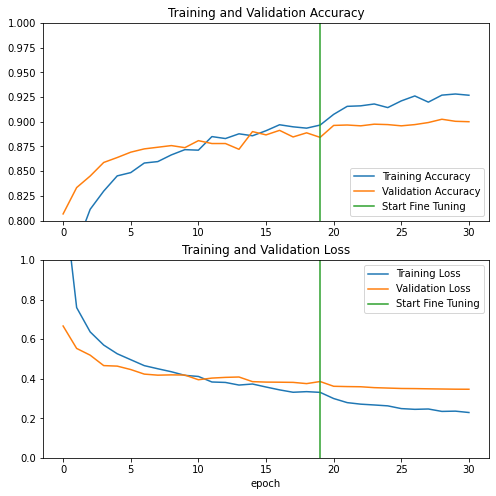

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Prediction of new samples and analysis

In [42]:
predictions = []
true_labels = []
imgs = []

for X, y in test_dataset :
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()
    pred = model.predict_on_batch(image_batch)
    pred = tf.nn.softmax(pred)
    imgs.append(image_batch)
    true_labels.append(label_batch)
    predictions.append(np.argmax(pred.numpy(),axis=1))
    
predictions = [item for sublist in predictions for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

predictions_sports = [INDEX_TO_CLASS[k] for k in predictions]
true_labels_sports = [INDEX_TO_CLASS[k] for k in true_labels]

2022-03-30 13:17:06.082566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:17:06.572705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:17:08.079359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:17:08.840716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:17:09.584332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:17:10.184839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data
2022-03-30 13:17:10.300573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:17:10.989925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-03-30 13:17:11.709309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning

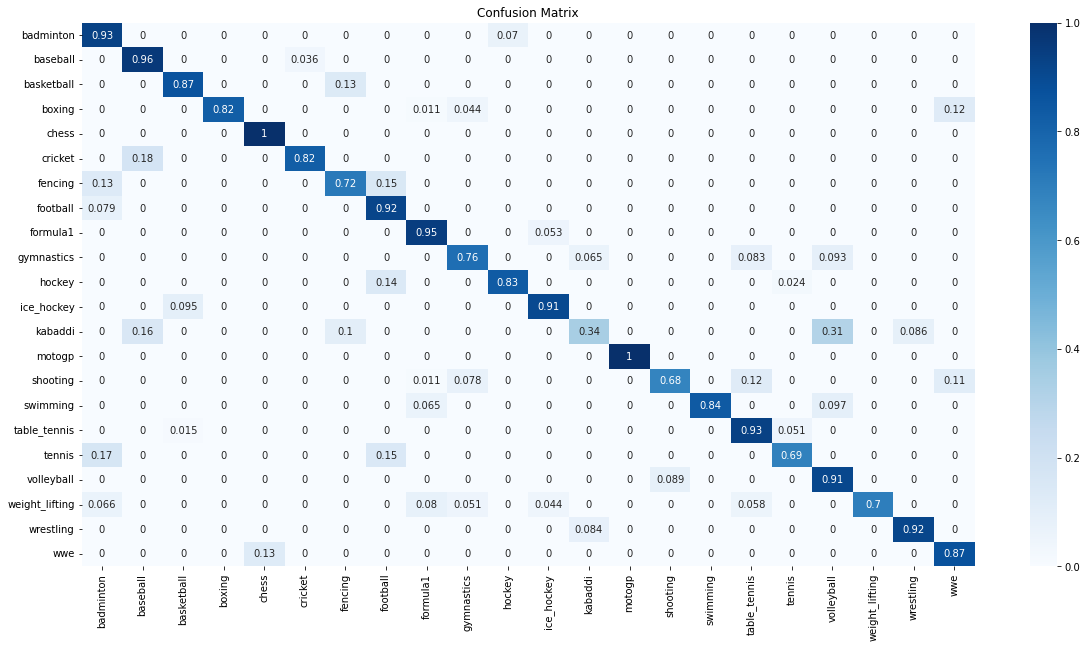

In [44]:
cf_matrix = confusion_matrix(true_labels_sports, predictions_sports, normalize='true')
plt.figure(figsize=(20, 10))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=sorted(
    set(true_labels_sports)), yticklabels=sorted(set(true_labels_sports)))
plt.title('Confusion Matrix')
plt.show()

In [45]:
 print(classification_report(true_labels_sports, predictions_sports, target_names=class_names))

                precision    recall  f1-score   support

     badminton       0.77      0.93      0.84       128
      baseball       0.82      0.96      0.88       138
    basketball       0.88      0.87      0.87        97
        boxing       1.00      0.82      0.90        90
         chess       0.93      1.00      0.96        91
       cricket       0.95      0.82      0.88       117
       fencing       0.78      0.72      0.75        93
      football       0.71      0.92      0.80        89
      formula1       0.87      0.95      0.91       133
    gymnastics       0.82      0.76      0.79       108
        hockey       0.89      0.83      0.86        84
    ice_hockey       0.87      0.91      0.89        95
       kabaddi       0.59      0.34      0.43        58
        motogp       1.00      1.00      1.00       101
      shooting       0.86      0.68      0.76        90
      swimming       1.00      0.84      0.91        93
  table_tennis       0.82      0.93      0.87  

In [46]:
loss_pred, accuracy = model.evaluate(test_dataset)
print("Test loss :", loss_pred)
print("Test accuracy :", accuracy)

2022-03-30 13:23:31.208212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 7/68 [==>...........................] - ETA: 6s - loss: 0.5260 - sparse_categorical_accuracy: 0.8527

2022-03-30 13:23:32.037816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


43/68 [=================>............] - ETA: 2s - loss: 0.6041 - sparse_categorical_accuracy: 0.8358

2022-03-30 13:23:35.206805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


50/68 [=====================>........] - ETA: 1s - loss: 0.6222 - sparse_categorical_accuracy: 0.8300

2022-03-30 13:23:35.689259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


68/68 [==============================] - 6s 82ms/step - loss: 0.6139 - sparse_categorical_accuracy: 0.8280
Test loss : 0.6138524413108826
Test accuracy : 0.8280459642410278


## Heatmap Visualization 

Let see the heatmaps associated to this model

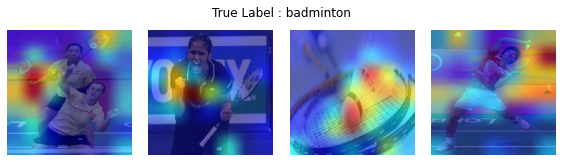

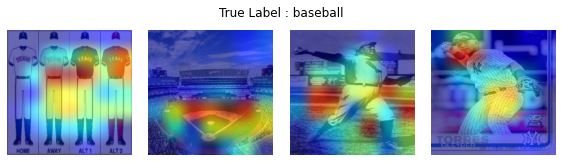

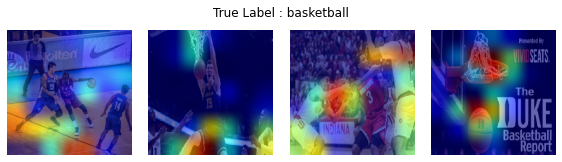

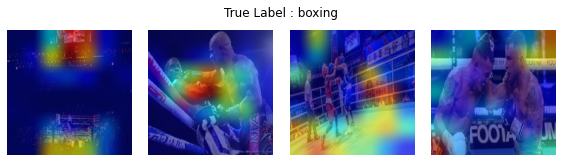

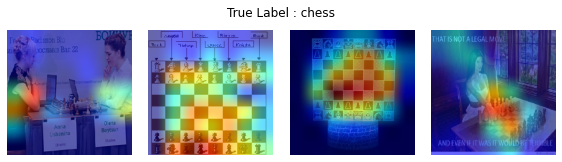

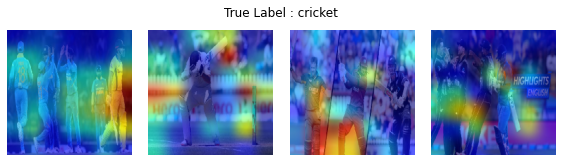

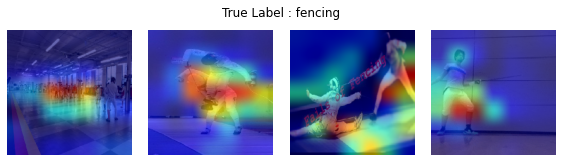

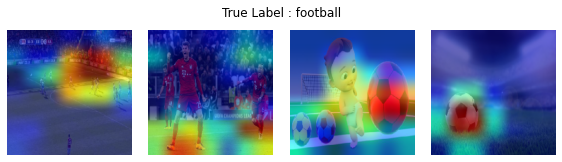

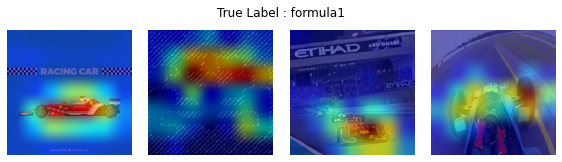

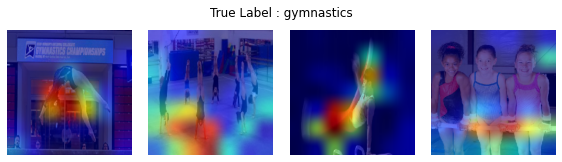

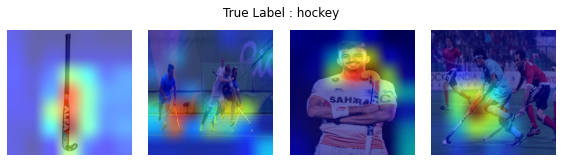

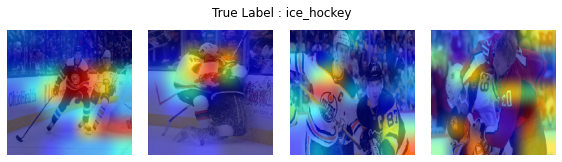

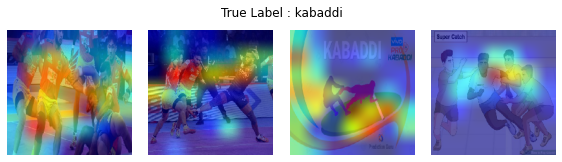

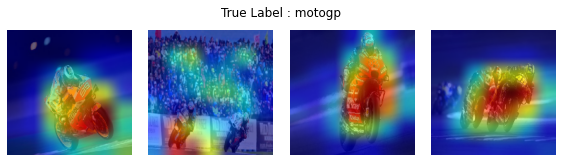

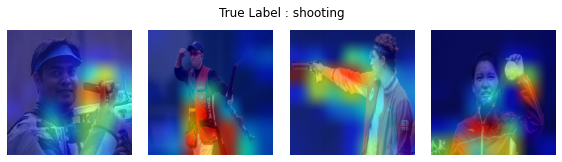

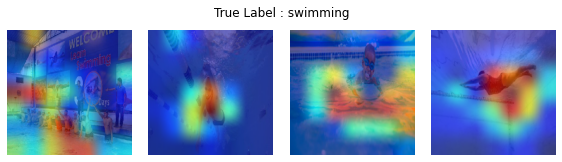

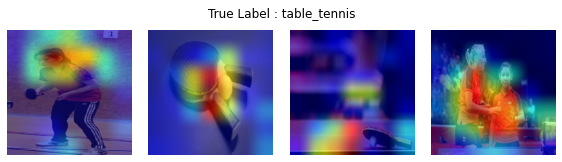

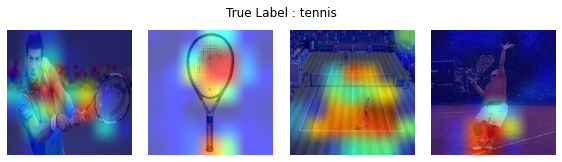

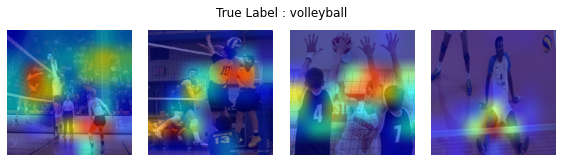

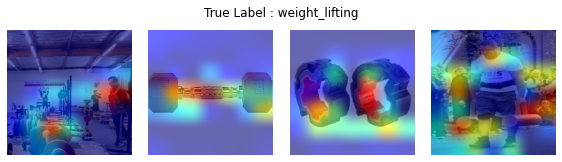

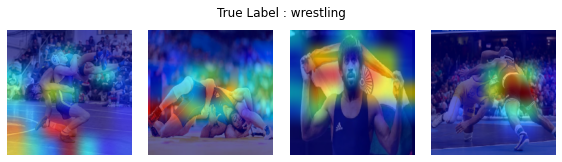

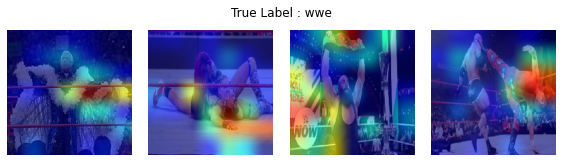

In [48]:
for sport in class_names:
    sport_folder = os.path.join(TEST_DATA, sport)
    sport_list = os.listdir(sport_folder)
    
    #img1_path = os.path.join(sport_folder, sport_list[random.randint(0, len(sport_list)-1)])
    #img2_path = os.path.join(sport_folder, sport_list[random.randint(0, len(sport_list)-1)])
    
    img1_path = os.path.join(sport_folder, sport_list[0])
    img2_path = os.path.join(sport_folder, sport_list[1])
    img3_path = os.path.join(sport_folder, sport_list[2])
    img4_path = os.path.join(sport_folder, sport_list[3])
    
    img1 = tf.keras.utils.load_img(img1_path, target_size=(224,224,3))
    img1 = keras.preprocessing.image.img_to_array(img1)
    img2 = tf.keras.utils.load_img(img2_path, target_size=(224,224,3))
    img2 = keras.preprocessing.image.img_to_array(img2)
    img3 = tf.keras.utils.load_img(img3_path, target_size=(224,224,3))
    img3 = keras.preprocessing.image.img_to_array(img3)
    img4= tf.keras.utils.load_img(img4_path, target_size=(224,224,3))
    img4 = keras.preprocessing.image.img_to_array(img4)
  
    heatmap1 = make_gradcam_heatmap(tf.expand_dims(img1,axis=0), resnet50_model, model, last_conv_layer_name, classifier_layer_names)
    heatmap2 = make_gradcam_heatmap(tf.expand_dims(img2,axis=0), resnet50_model, model, last_conv_layer_name, classifier_layer_names)
    heatmap3 = make_gradcam_heatmap(tf.expand_dims(img3,axis=0), resnet50_model, model, last_conv_layer_name, classifier_layer_names)
    heatmap4 = make_gradcam_heatmap(tf.expand_dims(img4,axis=0), resnet50_model, model, last_conv_layer_name, classifier_layer_names)
    
    # We rescale heatmap to a range 0-255
    heatmap1 = np.uint8(255 * heatmap1)
    heatmap2 = np.uint8(255 * heatmap2)
    heatmap3 = np.uint8(255 * heatmap3)
    heatmap4 = np.uint8(255 * heatmap4)
    
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap1 = jet_colors[heatmap1]
    jet_heatmap2 = jet_colors[heatmap2]
    jet_heatmap3 = jet_colors[heatmap3]
    jet_heatmap4 = jet_colors[heatmap4]

    # We create an image with RGB colorized heatmap
    jet_heatmap1 = keras.preprocessing.image.array_to_img(jet_heatmap1)
    jet_heatmap1 = jet_heatmap1.resize((224, 224))
    jet_heatmap1 = keras.preprocessing.image.img_to_array(jet_heatmap1)
    
    jet_heatmap2 = keras.preprocessing.image.array_to_img(jet_heatmap2)
    jet_heatmap2 = jet_heatmap2.resize((224, 224))
    jet_heatmap2 = keras.preprocessing.image.img_to_array(jet_heatmap2)

    jet_heatmap3 = keras.preprocessing.image.array_to_img(jet_heatmap3)
    jet_heatmap3 = jet_heatmap3.resize((224, 224))
    jet_heatmap3 = keras.preprocessing.image.img_to_array(jet_heatmap3)
    
    jet_heatmap4 = keras.preprocessing.image.array_to_img(jet_heatmap4)
    jet_heatmap4 = jet_heatmap4.resize((224, 224))
    jet_heatmap4 = keras.preprocessing.image.img_to_array(jet_heatmap4)

    # Superimpose the heatmap on original image
    superimposed_img1 = jet_heatmap1 * 1.5 + img1
    superimposed_img1 = keras.preprocessing.image.array_to_img(superimposed_img1)
    
    superimposed_img2 = jet_heatmap2 * 1.5 + img2
    superimposed_img2 = keras.preprocessing.image.array_to_img(superimposed_img2)
    
    superimposed_img3 = jet_heatmap3 * 1.5 + img3
    superimposed_img3 = keras.preprocessing.image.array_to_img(superimposed_img3)
    
    superimposed_img4 = jet_heatmap4 * 1.5 + img4
    superimposed_img4 = keras.preprocessing.image.array_to_img(superimposed_img4)
    
    plt.figure(figsize=(8, 8))
    
    plt.suptitle('True Label : ' +  str(sport))
    
    plt.subplot(4, 4, 1)
    plt.axis('off')
    plt.imshow(superimposed_img1)
    
    plt.subplot(4, 4, 2)
    plt.axis('off')
    plt.imshow(superimposed_img2)
    
    plt.subplot(4, 4, 3)
    plt.axis('off')
    plt.imshow(superimposed_img3)
    
    plt.subplot(4, 4, 4)
    plt.axis('off')
    plt.imshow(superimposed_img4)
    
    plt.tight_layout()
    plt.show()


# Remarks & Improvements

- So far, we can see that after Transfer Learning, the performance of the model is reasonable and that after Fine Tuning, it has improved a little bit. In fact, Fine Tuning helps just for confusion between some classes.
- In Data-Exploration, we have seen that there are some classes that have images quite similar between each others, such as tennis and badminton or wwe and wrestling. Consequently, it might be more interesting to introspect the quality of the images in the training set to check for ones that are too ambiguous and should be removed from it.
- The impact of the optimizer is important. One thing that can be done is to tune the most appropriate learning rate before executing the real training of the model in order to have better results.